# ComplexUpset
A library for creating complex UpSet plots based on `ggplot2` and `patchwork`.

## Install

From `R` console run:

```R
if(!require(devtools)) install.packages("devtools")
devtools::install_github("krassowski/complex-upset")
```

### Python integration for use in Jupyter Notebooks (optional)

Please install the requirements using:
    
```bash
pip install -r requirements.txt
```

Load `rpy2` extension:

In [1]:
%%capture
%load_ext rpy2.ipython

## Load ggplot2 and ComplexUpset

In [2]:
%%R
library(ggplot2)
library(ComplexUpset)

## Prepare the datasets

If you wish to use R only, you can use the movies dataset from `ggplot2movies` package. I trust that as an R user you now how to proceed from here.

### Python

In [3]:
from pydataset import data as load_data
movies = load_data('movies').dropna()
movies.head(3).T

,48,112,124
title,'Til There Was You,10 Things I Hate About You,100 Mile Rule
year,1997,1999,2002
length,113,97,98
budget,2.3e+07,1.6e+07,1.1e+06
rating,4.8,6.7,5.6
votes,799,19095,181
r1,4.5,4.5,4.5
r2,4.5,4.5,4.5
r3,4.5,4.5,4.5
r4,14.5,4.5,4.5


In [4]:
genres = list(movies.columns[-7:])
genres

['Action', 'Animation', 'Comedy', 'Drama', 'Documentary', 'Romance', 'Short']

Convert the genre indicator columns to use boolean values:

In [5]:
movies[genres] = movies[genres] == 1
movies[genres].head(3).T

,48,112,124
Action,False,False,False
Animation,False,False,False
Comedy,True,True,True
Drama,False,False,False
Documentary,False,False,False
Romance,True,True,False
Short,False,False,False


### Quick notes on `rpy2` `%%R` magic usage:

- use `-i` switch to import data into R using rpy2 interface
- `-w` and `-h` can be used to adjust the width and height of the plot
- `-r` switch can be used to adjust DPI

## 0. Basic usage

There are two required arguments:
- the first argument is expected to be a dataframe with both group indicator variables and covariates,
- the second argument specifies a list with names of column which indicate the group membership.

Additional arguments can be provided, such as `name` (specifies xlab for intersection matrix) or `width_ratio` (specifies how much space should be occupied by the set size panel). Other such arguments are discussed at length later in this document.

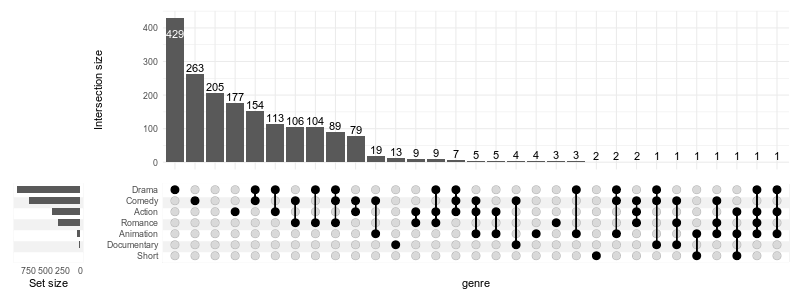

In [6]:
%%R -i movies -i genres -w 800 -h 300
upset(movies, genres, name='genre', width_ratio=0.1)

### 0.1) Selecting the intersections of specific size

We will focus on the intersections with at least ten members `(min_size=10)` and on a few variables which are significantly different between the intersections (see 2. Running statistical tests).

When using `min_size`, the empty groups will be skipped by default (e.g. *Short* movies would have no overlap with size of 10). To keep all groups pass `keep_empty_groups=TRUE`:

[1] "Dropping empty groups: Short"


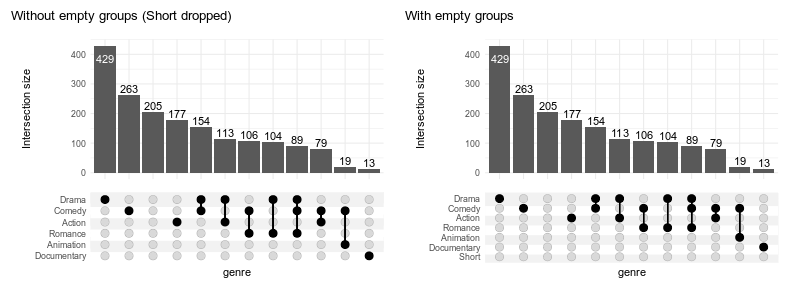

In [7]:
%%R -i movies -i genres -w 800 -h 300
(
    upset(movies, genres, name='genre', width_ratio=0.1, min_size=10, wrap=TRUE, overall_sizes=FALSE)
    + ggtitle('Without empty groups (Short dropped)')
    +
    upset(movies, genres, name='genre', width_ratio=0.1, min_size=10, keep_empty_groups=TRUE, wrap=TRUE, overall_sizes=FALSE)
    + ggtitle('With empty groups')
)

When empty columns are detected a warning will be issued. The silence it, pass `warn_when_dropping_groups=FALSE`.

## 1. Adding components

We can add multiple annotation components (also called panels):

[1] "Dropping empty groups: Short"


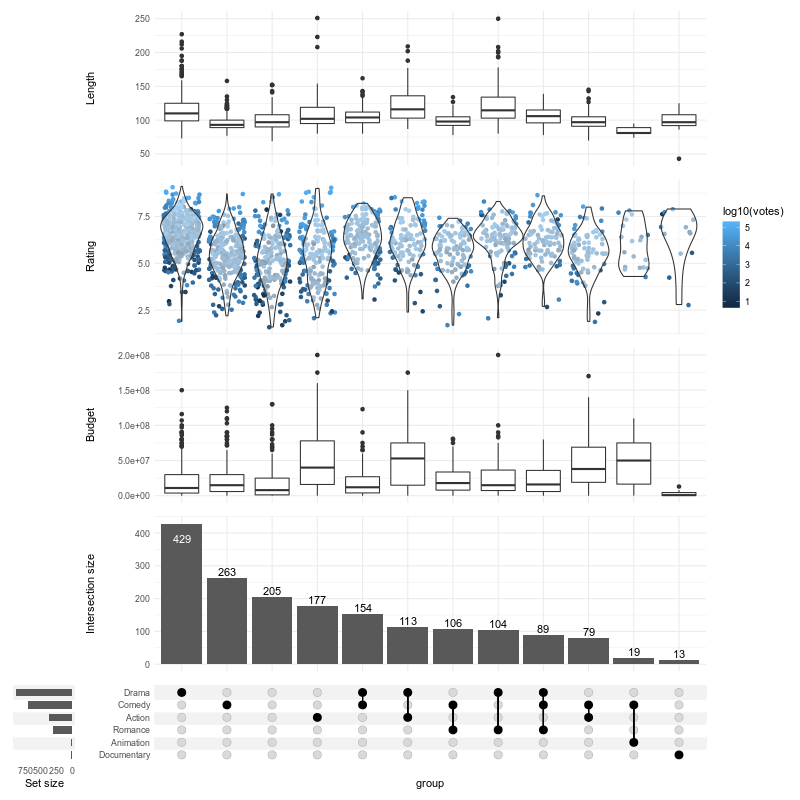

In [8]:
%%R -w 800 -h 800

set.seed(0)   # keep the same jitter for identical plots

upset(
    movies,
    genres,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot()
        ),
        'Rating'=list(
            aes=aes(x=intersection, y=rating),
            geom=list(
                # checkout ggbeeswarm::geom_quasirandom for better results!
                geom_jitter(aes(color=log10(votes))),
                geom_violin(width=1.1, alpha=0.5)
            )
        ),
        'Budget'=list(
            aes=aes(x=intersection, y=budget),
            geom=geom_boxplot()
        )
    ),
    min_size=10,
    width_ratio=0.1
)

For simple annotations, such as the length above, you can use a shorthand notation of `upset_annotate`:

[1] "Dropping empty groups: Short"


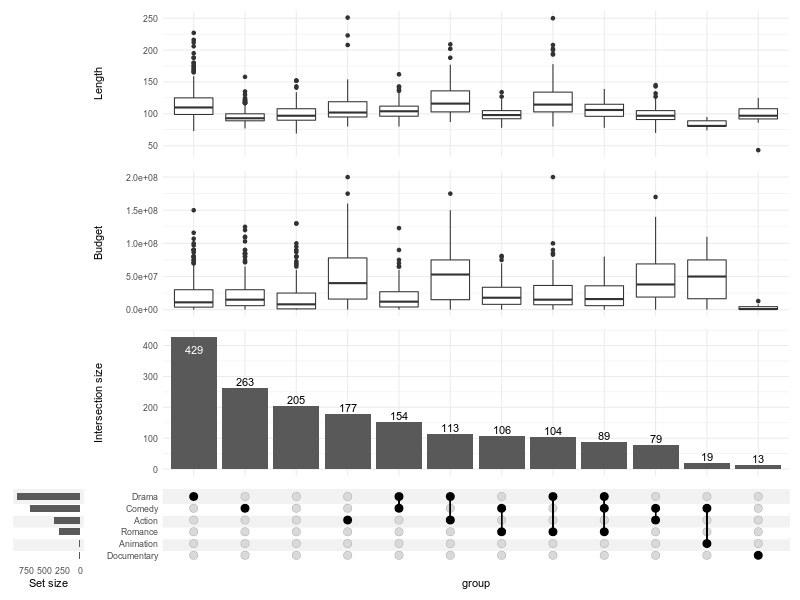

In [9]:
%%R -w 800 -h 600

upset(
    movies,
    genres,
    annotations = list(
        'Length'=upset_annotate('length', geom_boxplot()),
        'Budget'=upset_annotate('budget', geom_boxplot())
    ),
    min_size=10,
    width_ratio=0.1
)

You can also use of barplots to demonstrate difference in proportions of categorical variables:

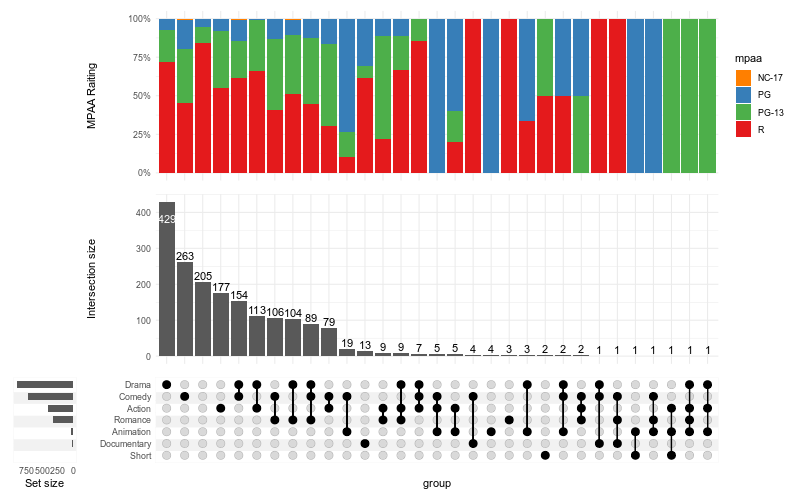

In [10]:
%%R -w 800 -h 500

upset(
    movies,
    genres,
    annotations = list(
        'MPAA Raiting'=list(
            aes=aes(x=intersection, fill=mpaa),
            geom=list(
                geom_bar(stat='count', position='fill'),
                scale_y_continuous(labels=scales::percent_format()),
                scale_fill_manual(values=c(
                    'R'='#E41A1C', 'PG'='#377EB8',
                    'PG-13'='#4DAF4A', 'NC-17'='#FF7F00'
                ))
            )
        )
    ),
    width_ratio=0.1
)

## 2. Running statistical tests

In [11]:
%R upset_test(movies, genres)

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"


,variable,p.value,statistic,test,fdr
length,length,6.511525e-71,422.884445,Kruskal-Wallis rank sum test,1.106959e-69
rating,rating,1.209027e-46,301.727638,Kruskal-Wallis rank sum test,1.027673e-45
budget,budget,3.899860e-44,288.974760,Kruskal-Wallis rank sum test,2.209921e-43
r8,r8,9.900004e-39,261.288151,Kruskal-Wallis rank sum test,4.207502e-38
mpaa,mpaa,3.732200e-35,242.779393,Kruskal-Wallis rank sum test,1.268948e-34
r9,r9,1.433256e-30,218.781602,Kruskal-Wallis rank sum test,4.060891e-30
r1,r1,2.211600e-23,180.327398,Kruskal-Wallis rank sum test,5.371029e-23
r4,r4,1.008119e-18,154.627715,Kruskal-Wallis rank sum test,2.142254e-18
r3,r3,2.568227e-17,146.702174,Kruskal-Wallis rank sum test,4.851095e-17
r5,r5,9.823827e-16,137.663096,Kruskal-Wallis rank sum test,1.670051e-15


`Kruskal-Wallis rank sum test` is not always the best choice.

You can either change the test for:
 - all the variables (`test=your.test`), or
 - specific variables (using `tests=list(variable=some.test)` argument)

The tests are called with `(formula=variable ~ intersection, data)` signature, such as accepted by `kruskal.test`. The result is expected to be a list with following members:
- `p.value`
- `statistic`
- `method`

It is easy to adapt tests which do not obey this signature/output convention; for example the Chi-squared test and anova can be wrapped with two-line functions as follows:

In [12]:
%%R
chisq_from_formula = function(formula, data) {
    chisq.test(
        ftable(formula, data)
    )
}

anova_single = function(formula, data) {
    result = summary(aov(formula, data))
    list(
        p.value=result[[1]][['Pr(>F)']][[1]],
        method='Analysis of variance Pr(>F)',
        statistic=result[[1]][['F value']][[1]]
    )
}

custom_tests = list(
    mpaa=chisq_from_formula,
    budget=anova_single
)

In [13]:
%R head(upset_test(movies, genres, comparisons=list(tests=custom_tests)))

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"


,variable,p.value,statistic,test,fdr
length,length,6.511525e-71,422.884445,Kruskal-Wallis rank sum test,1.106959e-69
budget,budget,1.348209e-60,13.663948,Analysis of variance Pr(>F),1.145977e-59
rating,rating,1.209027e-46,301.727638,Kruskal-Wallis rank sum test,6.851151e-46
mpaa,mpaa,9.799097e-42,406.338139,Pearson's Chi-squared test,4.164616e-41
r8,r8,9.900004e-39,261.288151,Kruskal-Wallis rank sum test,3.366002e-38
r9,r9,1.433256e-30,218.781602,Kruskal-Wallis rank sum test,4.060891e-30


Many tests will require at least two observations in each group. You can skip intersections with less than two members with `min_size=2`.

In [14]:
%R tail(upset_test(movies, genres, comparisons=list(test=bartlett.test, min_size=2)))

[1] "NA, year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, NA differ significantly between intersections"


,variable,p.value,statistic,test,fdr
year,year,1.041955e-67,386.536991,Bartlett test of homogeneity of variances,1.302444e-67
length,length,3.982729e-67,383.701476,Bartlett test of homogeneity of variances,4.595457e-67
budget,budget,7.637563e-50,298.899113,Bartlett test of homogeneity of variances,8.183103e-50
rating,rating,3.980194e-06,66.632766,Bartlett test of homogeneity of variances,3.980194e-06
title,title,NaN,NaN,Bartlett test of homogeneity of variances,NaN
mpaa,mpaa,NaN,NaN,Bartlett test of homogeneity of variances,NaN


### Ignore specific variables

You may want to exclude variables which are:
 - highly correlated and therefore interfering with the FDR calculation, or
 - simply irrelevant

In the movies example, the title variable is not a reasonable thing to compare. We can ignore it using:

In [15]:
%%R
# note: title no longer present
rownames(upset_test(movies, genres, comparisons=list(ignore=c('title'))))

[1] "year, length, budget, rating, votes, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, mpaa differ significantly between intersections"
 [1] "length" "rating" "budget" "r8"     "mpaa"   "r9"     "r1"     "r4"    
 [9] "r3"     "r5"     "r7"     "r2"     "r10"    "votes"  "r6"     "year"  


## 3. Adjusting "Intersection size" aesthetics

### 3.1 Counts

The counts over the bars can be disabled:

[1] "Dropping empty groups: Short"


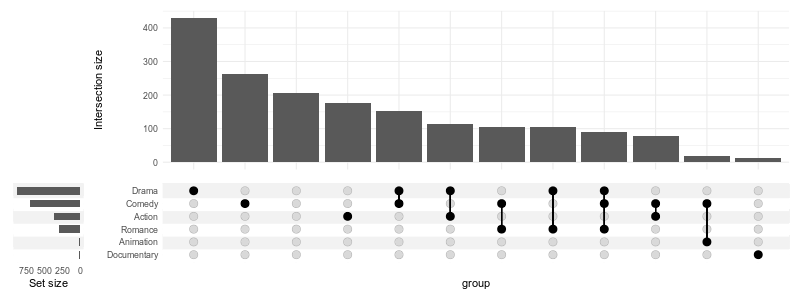

In [16]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(counts=FALSE)
    ),
    min_size=10,
    width_ratio=0.1
)

The colors can be changed:

[1] "Dropping empty groups: Short"


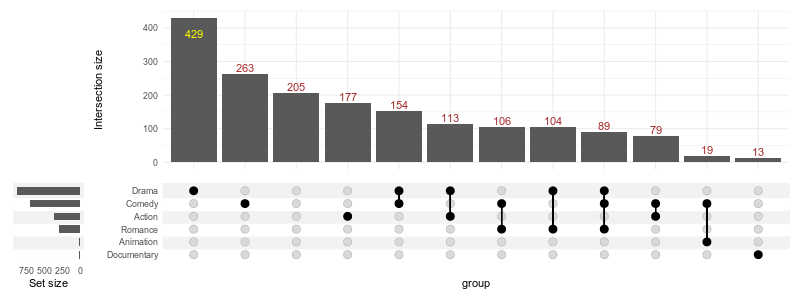

In [17]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text_colors=c(
                on_background='brown', on_bar='yellow'
            )
        )
    ),
    min_size=10,
    width_ratio=0.1
)

Any parameter supported by `geom_text` can be passed in `text` list:

[1] "Dropping empty groups: Short"


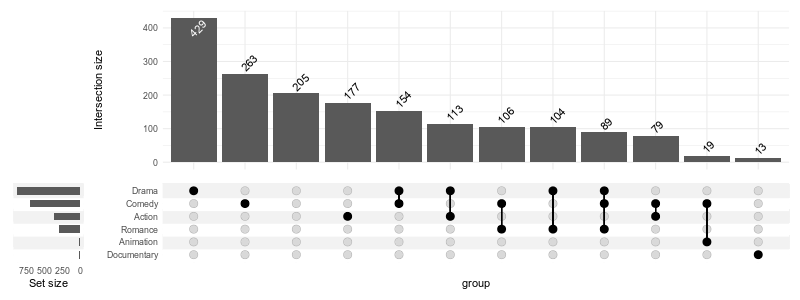

In [18]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            text=list(
                vjust=-0.1,
                hjust=-0.1,
                angle=45
            )
        )
    ),
    min_size=10,
    width_ratio=0.1
)

### 3.2 Fill the bars

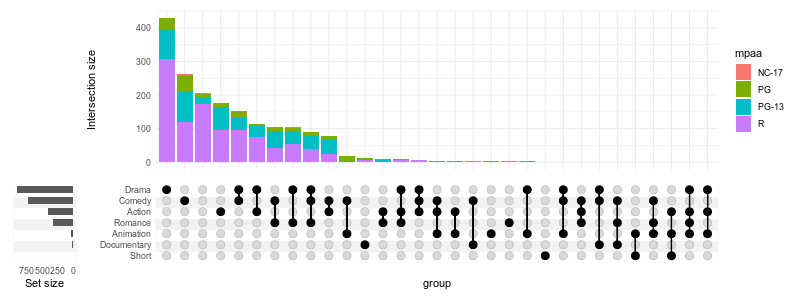

In [19]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    base_annotations=list(
        'Intersection size'=intersection_size(
            counts=FALSE,
            aes=aes(fill=mpaa)
        )
    ),
    width_ratio=0.1
)

### 3.3 Adjusting the height of the matrix/intersection size

Setting `height_ratio=1` will cause the intersection matrix and the intersection size to have an equal height:

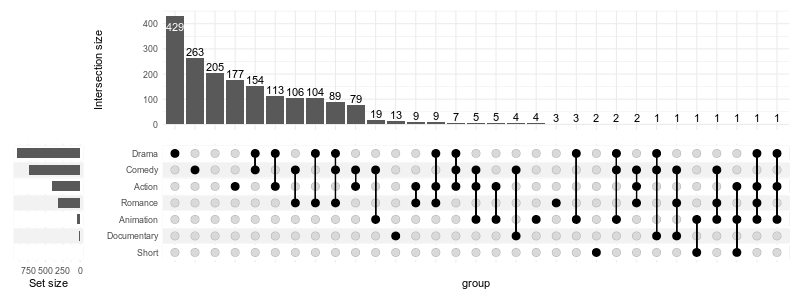

In [20]:
%%R -w 800 -h 300

upset(
    movies,
    genres,
    height_ratio=1,
    width_ratio=0.1
)

### 3.5 Hiding intersection size

You can always disable the intersection size altogether:

[1] "Dropping empty groups: Short"


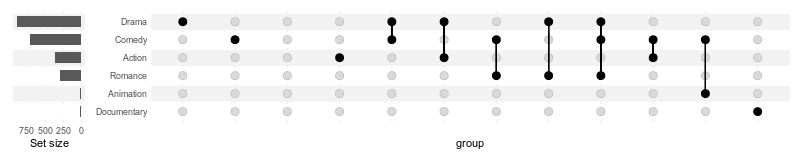

In [21]:
%%R -w 800 -h 160
upset(
    movies,
    genres,
    base_annotations=list(),
    min_size=10,
    width_ratio=0.1
)

### 3.6 Showing intersection size/union size ratio 

While this cannot be computed for the null intersection (observations which do not belong to either of the groups), it is usefull to visualise which intersections might be large due to the chance (i.e. corrsponding groups being proportionally larger) alone:

[1] "Dropping empty groups: Short"


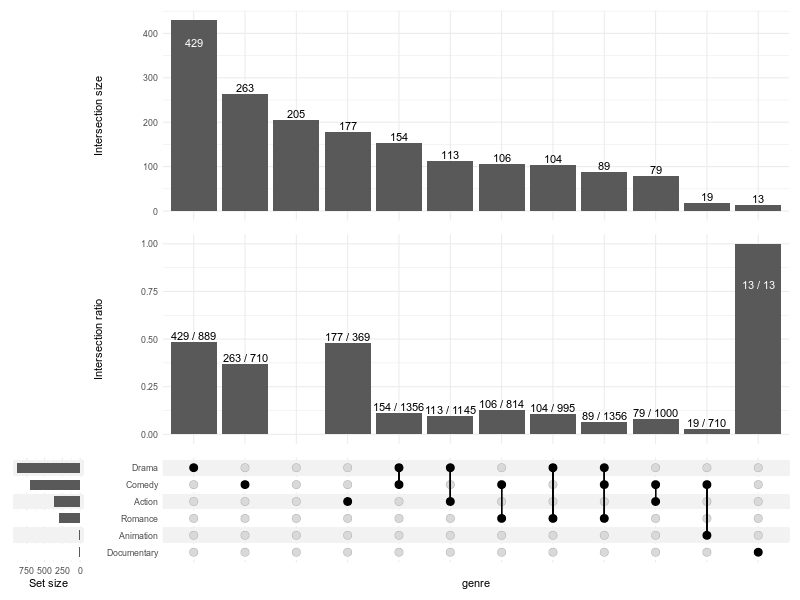

In [22]:
%%R -w 800 -h 600
upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    base_annotations=list(
        'Intersection size'=intersection_size(),
        'Intersection ratio'=intersection_ratio()
    )
)

The plot above tells us that the analysed documentary movies are always documentaries (and nothing more!), while comedies more often include elements of other genres (e.g. drama, romance) rather than being comedies alone (like stand-up shows).

### 3.7 Showing percentages

`text_aes` can be used to manipulate the aesthetics of the labels. Using the `intersection_size` and `union_size` one can calculate percentage of items in the intersection (relative to the potential size of the intersection). A `upset_text_percentage(digits=0, sep='')` shorthand is provided for convenience; please note that it has to be used with `aes_` rather than `aes`:

[1] "Dropping empty groups: Short"


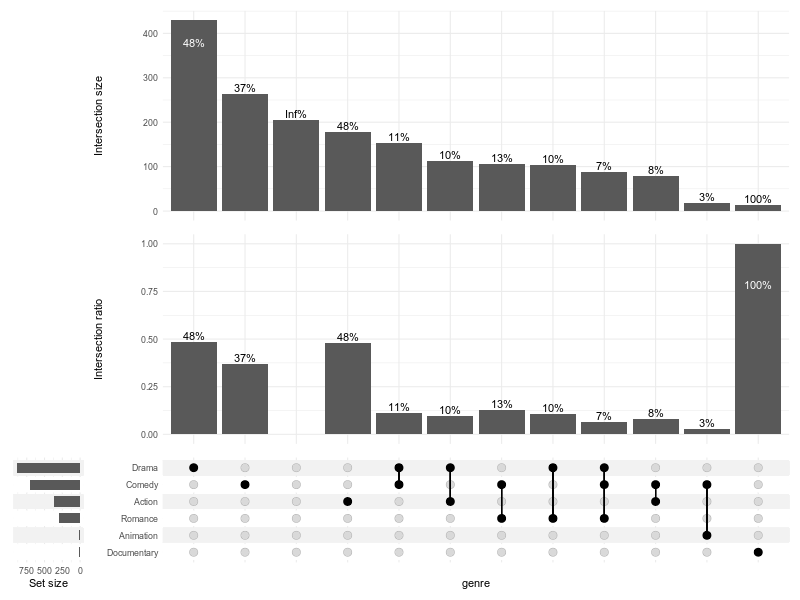

In [23]:
%%R -w 800 -h 600
upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    base_annotations=list(
        # with manual aes specification:
        'Intersection size'=intersection_size(text_aes=aes(label=paste0(round(intersection_size/union_size * 100), '%'))),
        # using shorthand:
        'Intersection ratio'=intersection_ratio(text_aes=aes_(label=upset_text_percentage()))
    )
)

## 4. Adjusting other aesthetics

### Stripes

[1] "Dropping empty groups: Short"


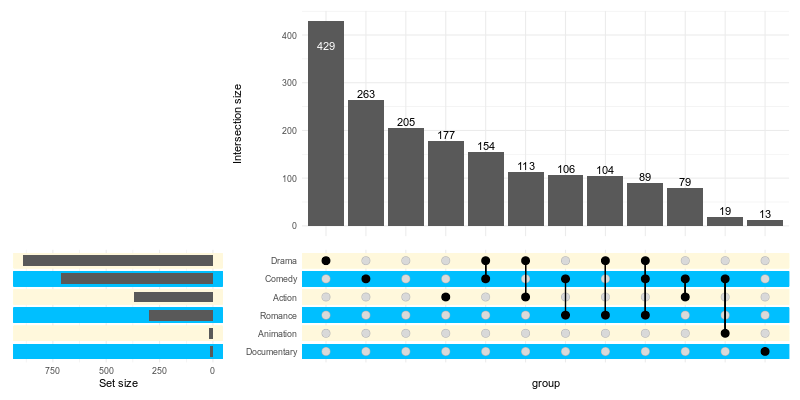

In [24]:
%%R -w 800 -h 400
upset(
    movies,
    genres,
    stripes=c('cornsilk1', 'deepskyblue1'),
    min_size=10
)

To effectively disable the stripes:

[1] "Dropping empty groups: Short"


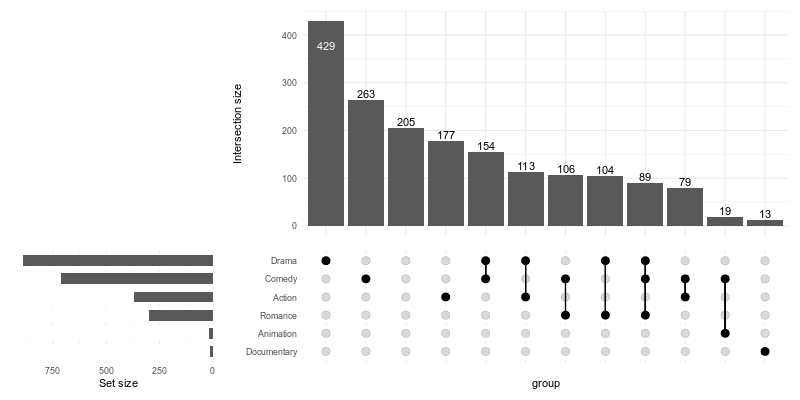

In [25]:
%%R -w 800 -h 400
upset(
    movies,
    genres,
    stripes=c('white', 'white'),
    min_size=10
)

### Adding title

Adding title with `ggtitle` with add it to the intesection matrix:

[1] "Dropping empty groups: Short"


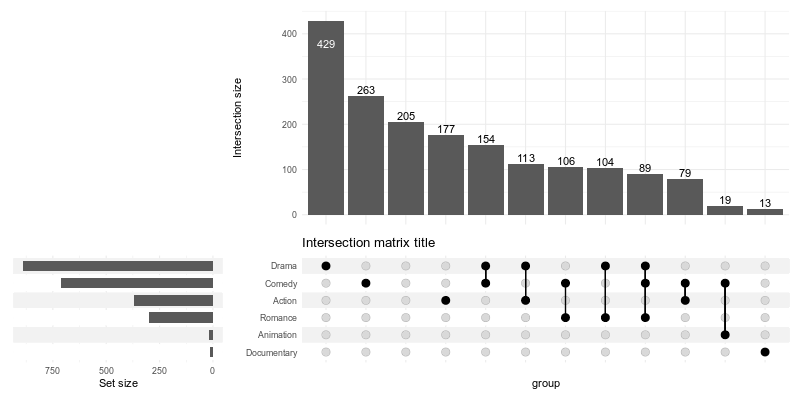

In [26]:
%%R -w 800 -h 400
upset(movies, genres, min_size=10) + ggtitle('Intersection matrix title')

In order to add a title for the entire plot, you need to wrap the plot:

[1] "Dropping empty groups: Short"


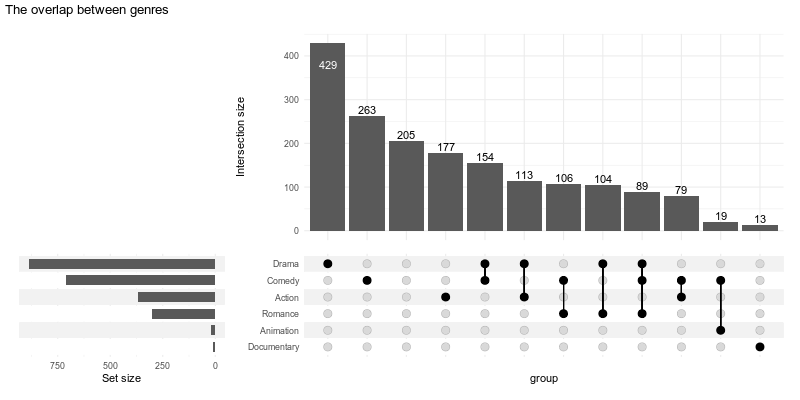

In [27]:
%%R -w 800 -h 400
upset(movies, genres, min_size=10, wrap=TRUE) + ggtitle('The overlap between genres')

## 5. Themes

The themes for specific components are defined in `upset_themes` list, which contains themes for:

In [28]:
%%R
names(upset_themes)

[1] "intersections_matrix" "Intersection size"    "overall_sizes"       
[4] "default"             


You can substitute this list for your own using `themes` argument. While you can specify a theme for every component, if you omit one or more components those will be taken from the element named `default`.

[1] "Dropping empty groups: Short"


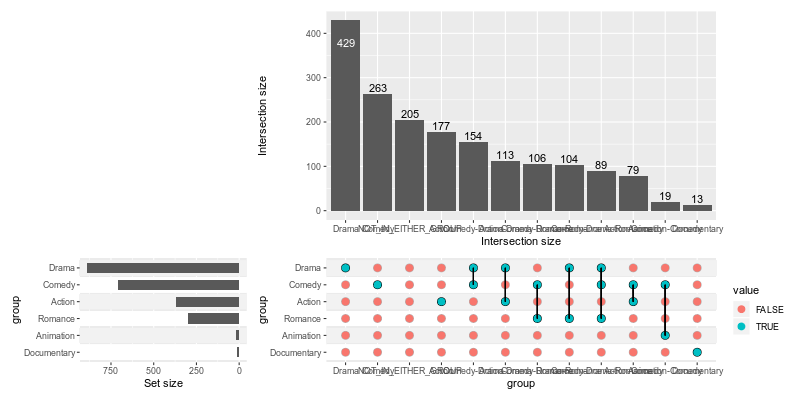

In [29]:
%%R -w 800 -h 400
upset(movies, genres, min_size=10, themes=list(default=theme()))

You can also add themes for your custom panels/annotations:

[1] "Dropping empty groups: Short"


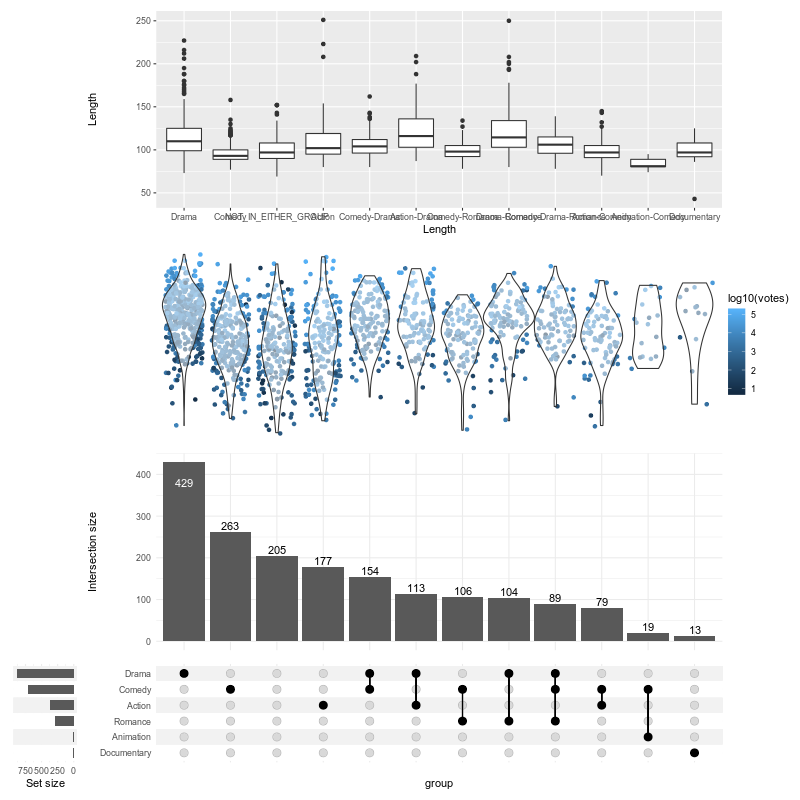

In [30]:
%%R -w 800 -h 800

upset(
    movies,
    genres,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot()
        ),
        'Rating'=list(
            aes=aes(x=intersection, y=rating),
            geom=list(
                geom_jitter(aes(color=log10(votes))),
                geom_violin(width=1.1, alpha=0.5)
            )
        )
    ),
    min_size=10,
    width_ratio=0.1,
    themes=modifyList(
        upset_themes,
        list(Rating=theme_void(), Length=theme())
    )
)

## 6. Highlighting (queries)

Pass a list of lists generated with `upset_query()` utility to the optional `queries` argument to selectively modify aesthetics of specific intersections or sets.

Use one of the arguments: `set` or `intersection` (not both) to specify what to highlight:
- `set` will highlight the bar of the set size,
- `intersection` will highlight an intersection on all components (by default), or on components chosen with `only_components`
- all other parameters will be used to modify the geoms

[1] "Dropping empty groups: Short"


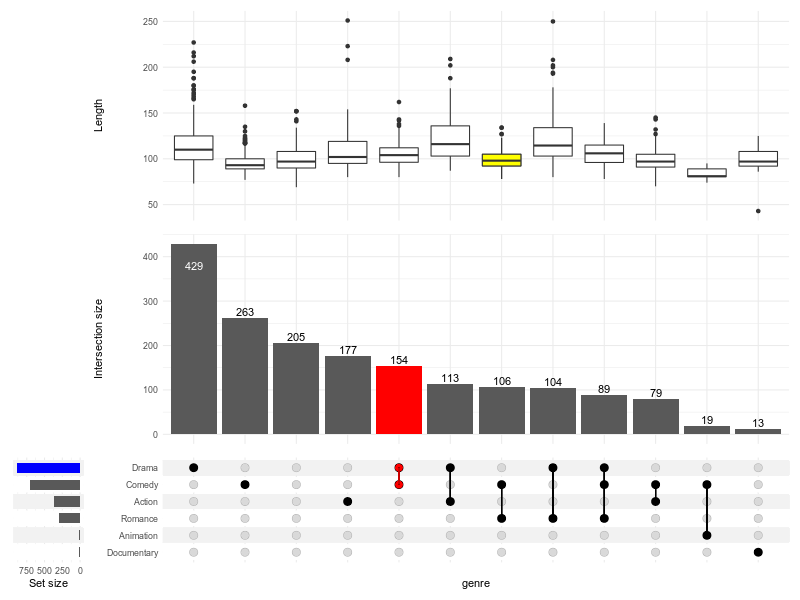

In [31]:
%%R -w 800 -h 600

upset(
    movies, genres, name='genre', width_ratio=0.1, min_size=10,
    annotations = list(
        'Length'=list(
            aes=aes(x=intersection, y=length),
            geom=geom_boxplot()
        )
    ),
    queries=list(
        upset_query(
            intersect=c('Drama', 'Comedy'),
            color='red',
            fill='red',
            only_components=c('intersections_matrix', 'Intersection size')
        ),
        upset_query(
            set='Drama',
            fill='blue'
        ),
        upset_query(
            intersect=c('Romance', 'Comedy'),
            fill='yellow',
            only_components=c('Length')
        )
    )
)